In [1]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import pandas as pd

np.random.seed(788) # Random seed

The function *Kroupa IMF* generates stellar masses according to the Kroupa IMF distribution in the range [0.01,100] M$_\odot$. It returns *masses* (1D array, float type), i.e., the masses of all the stars in the system in M$_\odot$.

In [2]:
def Kroupa_IMF(N_masses, m_min, m_max):

    def Kroupa_IMF_extraction(N=1, m_min=0.01, m_max=100):
    
        alpha_1 = 0.3
        alpha_2 = 1.3
        alpha_3 = 2.3
    
        m_change_1 = 0.08
        m_change_2 = 0.5
    
        continuity_1 = m_change_1**(alpha_2-alpha_1)
        continuity_2 = continuity_1*m_change_2**(alpha_3-alpha_2)

        norm_1 = (m_change_1**(1-alpha_1)-m_min**(1-alpha_1))/(1-alpha_1)
        norm_2 = continuity_1*(m_change_2**(1-alpha_2)-m_change_1**(1-alpha_2))/(1-alpha_2)
        norm_3 = continuity_2*(m_max**(1-alpha_3)-m_change_2**(1-alpha_3))/(1-alpha_3)

        norm = norm_1 + norm_2 + norm_3

        P_m = np.random.uniform(0,1,N)
        mask_light_1 = (norm*P_m - norm_1 < 0)
        mask_light_2 = (norm*P_m - norm_2 - norm_1 < 0) & (norm*P_m - norm_1 > 0)
        mask_heavy = (norm*P_m - norm_2 - norm_1 > 0)

        P_light_1 = P_m[mask_light_1]
        P_light_2 = P_m[mask_light_2]
        P_heavy = P_m[mask_heavy]

        m_light_1 = ((1-alpha_1)*(norm*P_light_1) + m_min**(1-alpha_1))**(1/(1-alpha_1))
        m_light_2 = ((1-alpha_2)*(norm*P_light_2-norm_1)/continuity_1 + m_change_1**(1-alpha_2))**(1/(1-alpha_2))
        m_heavy = ((1-alpha_3)*(norm*P_heavy-norm_1-norm_2)/continuity_2 + m_change_2**(1-alpha_3))**(1/(1-alpha_3))

        m_tot = np.concatenate((m_light_1,m_light_2,m_heavy), axis=0)
        np.random.shuffle(m_tot)
    
        return m_tot

    masses = Kroupa_IMF_extraction(N=N_masses)
    
    while True:
        mask_masses = (masses < m_min) | (masses> m_max)
        masses_accepted_1 = masses[~mask_masses]
        N_rejected = mask_masses.sum()
        if N_rejected == 0:
            break
        masses_accepted_2 = Kroupa_IMF_extraction(N=N_rejected)
        masses = np.concatenate((masses_accepted_1,masses_accepted_2), axis=0)

    np.random.shuffle(masses)
    
    return masses

This cell allows the user to compute the mean mass of the system in the selected mass range following the Kroupa IMF. The variable *m$_{mean}$* is a keyword of the *main program*: the user must insert its value in the header, together with the total number of stars *N$_{tot}$* and the binary fraction *f$_b$*.

In [3]:
masses = Kroupa_IMF(10**7, 0.1, 100)

m_mean = np.mean(masses)

print('Mean mass in the selected mass range:', m_mean)

Mean mass in the selected mass range: 0.6381383461965906


The function *mass ratio* extracts *q* values from a power-law mass ratio distribution *f(q) $\propto q^{(-4)}$* in the range *q* $\in [0.01,1]$; it hence returns the mass ratio *q* (1D array, float type).

In [4]:
def mass_ratio(N_b, q_min=0.01, q_max=1, beta=-0.4):
    
    norm_q = ((1/(beta+1))*(q_max**(beta+1) - q_min**(beta+1)))
    X_q = np.random.uniform(0,1,N_b)
    q = pow(norm_q*(beta+1)*X_q + q_min**(beta+1),1/(beta+1))

    return q

The function *stellar masses* assigns masses extracted from the Kroupa IMF to single stars and primary components of binary stars, from the multiplication of which times a *q* value those of secondaries are generated. All masses are finally corrected for their sum to match the imposed system's total mass. The function returns, after correction:

1) *m$_s$* : masses of single stars in M$_\odot$ (1D array, float type);

2) *m$_1$* : masses of primaries in M$_\odot$ (1D array, float type);

3) *m$_2$* : masses of secondaries in M$_\odot$ (1D array, float type);

4) *m$_{cm}$* : masses of binary barycenters in M$_\odot$ (1D array, float type);

5) *m* : masses of single stars and binary barycenters in M$_\odot$ (1D array, float type);

6) *m$_{tot}$* : masses of single stars, primaries and secondaries in M$_\odot$ (1D array, float type);

7) *M* : system's total mass in M$_\odot$ (float type variable).

In [5]:
def stellar_masses(N_s, N_tot, masses, m_mean, q):
    
    m_s = masses[:N_s]
    m_1 = masses[N_s:]
    m_2 = m_1*q
    
    M = np.sum(np.concatenate((m_s,m_1,m_2), axis=0))
    M_tot = m_mean*N_tot
    
    correction = M_tot/M
    
    m_s = m_s*correction
    m_1 = m_1*correction
    m_2 = m_2*correction
    
    m_cm = m_1 + m_2
    m = np.concatenate((m_s,m_cm), axis=0)
    m_tot = np.concatenate((m_s,m_1,m_2), axis=0)
    
    M = int(np.sum(m_tot))
    
    return m_s, m_1, m_2, m_cm, m, m_tot, M

The function *positions* determines the positions of single stars and binary centers of mass according to the Plummer model, and returns:

1) *r* : position vectors' magnitudes in pc (1D array, float type);

2) *X* : position vectors' components in pc (*N*$\times$3 matrix, each line referring to a star and each column to a position component, i.e., *x*, *y*, *z*).

In [6]:
def positions(R, N):
    
    P_r = np.random.uniform(0,1,N)
    P_theta = np.random.uniform(-1,1,N)
    P_phi = np.random.uniform(0,2*np.pi,N)

    theta = np.arccos(P_theta)
    phi = P_phi
    
    r = (1/np.sqrt(pow(P_r,-2/3) - 1))*R # pc
    
    X = np.zeros(shape=(N,3))

    X[:,0] = r*np.sin(theta)*np.cos(phi)
    X[:,1] = r*np.sin(theta)*np.sin(phi)
    X[:,2] = r*np.cos(theta)
    
    return r, X

The function *single positions* assigns the extracted positions to single stars; therefore, it returns single stellar position vectors' components in pc (*X$_s$* : *N$_s$*$\times$3 matrix, each line referring to a star and each column to a position component, i.e., *x$_s$*, *y$_s$*, *z$_s$*).

In [7]:
def single_positions(N_s, r, X):
    
    r_s = r[:N_s] # Positions of single stars
    X_s = X[:N_s]
    
    return X_s

The function *binary positions* determines the positions of both binary centres of mass and binary components, by assuming as a location the apocenter of their respective orbit for computational convenience. In particular, the positions of binary components are evaluated in the system reference frame. The function returns:

1) *X$_1$* : position vectors' components of primaries in pc (*N$_b$*$\times$3 matrix, each line referring to a primary star and each column to a position component, i.e., *x$_1$*, *y$_1$*, *z$_1$*);

2) *X$_2$* : position vectors' components of secondaries in pc (*N$_b$*$\times$3 matrix, each line referring to a secondary star and each column to a position component, i.e., *x$_2$*, *y$_2$*, *z$_2$*).

In [8]:
def binary_positions(N_s, N_b, r, X, m_1, m_2, a, e):
    
    r_cm = r[N_s:] # Positions of binary centers of mass
    X_cm = X[N_s:]
    
    r_apo = a*(1+e) # Apocenter radius

    nx = 2*np.random.uniform(0,1,N_b) - 1
    ny = 2*np.random.uniform(0,1,N_b) - 1
    nz = 2*np.random.uniform(0,1,N_b) - 1 
    
    nx_norm = nx/np.sqrt(nx**2+ny**2+nz**2)
    ny_norm = ny/np.sqrt(nx**2+ny**2+nz**2)
    nz_norm = nz/np.sqrt(nx**2+ny**2+nz**2)
    
    X_apo = np.zeros(shape=(len(r_apo),3))
    X_apo[:,0] = nx_norm*r_apo
    X_apo[:,1] = ny_norm*r_apo
    X_apo[:,2] = nz_norm*r_apo
    
    # Position components of primaries
    
    X_1 = np.zeros(shape=(len(r_apo),3))

    X_1[:,0] = X_cm[:,0] + m_2*X_apo[:,0]/(m_1+m_2)
    X_1[:,1] = X_cm[:,1] + m_2*X_apo[:,1]/(m_1+m_2)
    X_1[:,2] = X_cm[:,2] + m_2*X_apo[:,2]/(m_1+m_2)

    # Position components of secondaries
    
    X_2 = np.zeros(shape=(len(r_apo),3))
    
    X_2[:,0] = X_cm[:,0] - m_1*X_apo[:,0]/(m_1+m_2)
    X_2[:,1] = X_cm[:,1] - m_1*X_apo[:,1]/(m_1+m_2)
    X_2[:,2] = X_cm[:,2] - m_1*X_apo[:,2]/(m_1+m_2)

    return X_1, X_2

The function *velocities* extracts the velocities of both single stars and binary centers of mass according to the Plummer model, provided that they do not exceed in magnitude the associated escape velocity (condition evaluated through an accept-reject method), and returns:

1) *v* : velocity vectors' magnitudes in pc/Myr (1D array, float type);

2) *V* : velocity vectors' components in pc/Myr (*N*$\times$3 matrix, each line referring to a star and each column to a velocity component, i.e., *v$_x$*, *v$_y$*, *v$_z$*).

In [9]:
def velocities(R, N, M, r):
    
    n_samples = 0
    v = []

    while n_samples < N:
        x_t = np.random.uniform(0,1)
        y_t = 0.1*np.random.uniform(0,1)
        
        if (x_t**2)*(1-x_t**2)**(3.5) > y_t: 
            v.append(x_t)
            n_samples +=1
            
    r = r/R
    ve = np.sqrt(2)*(1+r**2)**(-0.25)
    
    v = np.asarray(v)*ve*np.sqrt(G*M/R) # km/s
    v = 1.023*v # pc/Myr
        
    n1 = np.random.uniform(0,1,N)
    n2 = np.random.uniform(0,1,N)

    V = np.zeros(shape=(N,3))

    V[:,0] = (1 - 2*n1)*v
    V[:,1] = np.sqrt(pow(v,2) - pow(V[:,0],2))*np.sin(2*np.pi*n2)
    V[:,2] = np.sqrt(pow(v,2) - pow(V[:,0],2))*np.cos(2*np.pi*n2)

    return v, V

The function *virial ratio* calculates the kinetic and the potential energy of the system (indicated by *T* and *U*, respectively), which are used to determine the virial ratio *Q* (float type). The purpose of the function is checking that the virial equilibrium is effectively obtained, i.e., that *Q* = 0.5.

In [10]:
def virial_ratio(R, G, m, M, X, v):

    T = np.sum(m*pow(v,2)/2)
    
    U = 0
    for i in range(len(X)-1):
        x_eff = X[i+1:,0]
        y_eff = X[i+1:,1]
        z_eff = X[i+1:,2]
        l = len(x_eff)
        
        x_i = X[i,0]*np.ones(l)
        y_i = X[i,1]*np.ones(l) 
        z_i = X[i,2]*np.ones(l)
        
        inverse_distance = 1/np.sqrt((x_i - x_eff)**2 + (y_i - y_eff)**2 +(z_i-z_eff)**2)
        U += -G*m[i]*np.sum(np.dot(m[i+1:],inverse_distance))
                
    Q = T/abs(U)
    
    return Q

The function *single velocities* assigns the extracted velocities to single stars and returns single stellar velocity vectors' components in pc/Myr (*V$_s$* : *N$_s$*$\times$3 matrix, each line referring to a star and each column to a velocity component, i.e., *v$_{s,x}$*, *v$_{s,y}$*, *v$_{s,z}$*).

In [11]:
def single_velocities(N_s, v, V):
    
    v_s = v[:N_s] 
    V_s = V[:N_s]
    
    return V_s 

The function *binary velocities* assigns the remaining extracted velocities to binary centers of mass and determines the velocities of binary components by accounting for the additional orbital motion, expressed through the mean orbital velocity. The function returns:

1) *V$_1$* : velocity vectors' components of primaries in pc/Myr (*N$_b$*$\times$3 matrix, each line referring to a star and each column to a velocity component, i.e., *v$_{1,x}$*, *v$_{1,y}$*, *v$_{1,z}$*);

2) *V$_2$* : velocity vectors' components of secondaries in pc/Myr (*N$_b$*$\times$3 matrix, each line referring to a star and each column to a velocity component, i.e., *v$_{2,x}$*, *v$_{2,y}$*, *v$_{2,z}$*).

In [12]:
def binary_velocities(N_s, N_b, v, V, m_1, m_2, a):
    
    v_cm = v[N_s:] # Velocities of binary centers of mass
    V_cm = V[N_s:]
    
    m_1.reshape(N_b)
    m_2.reshape(N_b)
      
    v_orb_mean = np.sqrt(G*(m_1+m_2)/a) # Mean orbital velocity

    nx = 2*np.random.uniform(0,1,N_b) - 1
    ny = 2*np.random.uniform(0,1,N_b) - 1
    nz = 2*np.random.uniform(0,1,N_b) - 1

    nx_norm = nx/np.sqrt(nx**2 + ny**2 + nz**2)
    ny_norm = ny/np.sqrt(nx**2 + ny**2 + nz**2)
    nz_norm = nz/np.sqrt(nx**2 + ny**2 + nz**2)
    
    V_apo = np.zeros(shape=(N_b,3))
    
    V_apo[:,0] = nx_norm*v_orb_mean
    V_apo[:,1] = ny_norm*v_orb_mean
    V_apo[:,2] = nz_norm*v_orb_mean
    
    # Velocity components of primaries
    
    V_1 = np.zeros(shape=(N_b,3))

    V_1[:,0] = V_cm[:,0] + m_2*V_apo[:,0]/(m_1+m_2)
    V_1[:,1] = V_cm[:,1] + m_2*V_apo[:,1]/(m_1+m_2)
    V_1[:,2] = V_cm[:,2] + m_2*V_apo[:,2]/(m_1+m_2)
    
    # Velocity components of secondaries
    
    V_2 = np.zeros(shape=(N_b,3))
    
    V_2[:,0] = V_cm[:,0] - m_1*V_apo[:,0]/(m_1+m_2)
    V_2[:,1] = V_cm[:,1] - m_1*V_apo[:,1]/(m_1+m_2)
    V_2[:,2] = V_cm[:,2] - m_1*V_apo[:,2]/(m_1+m_2)
    
    return V_cm, V_1, V_2

The function *semi-major axis* extracts binary semi-major axes from a flat distribution *f(a) = 1/a* in the desired range of values [*a$_{au,min}$*,*a$_{au,max}$*], and returns:

1) *a$_{au}$* : semi-major axes in AU (1D array, float type);

2) *a* : semi-major axes in pc (1D array, float type).

In [13]:
def semi_major_axis(N_b, a_au_min, a_au_max):
    
    X_a = np.random.uniform(0,1,N_b)
    norm_a = np.log(a_au_max/a_au_min)
     
    a_au = np.exp((norm_a*X_a)+np.log(a_au_min))
    a = a_au/206264.55529277
    
    return a_au, a

The function *eccentricity* samples eccentricities from a thermal distribution *f(e) = 2e* in the desired range of values [*e*$_{min}$,*e*$_{max}$], hence returning the eccentricity *e* (1D array, float type).

In [14]:
def eccentricity(N_b, e_min, e_max):
    
    norm_e = pow(e_max,2) - pow(e_min,2)
    X_e = np.random.uniform(0,1,N_b)
    e = np.sqrt(norm_e*X_e + pow(e_min,2))

    return e

The function *plot distributions* displays the trend of the previously implemented distribution functions from sampled data. In order, panels show:

1) the Kroupa IMF *f(m)*;

2) the mass ratio distribution *f(q)*;

3) the semi-major axis distribution *f(a)*;

4) the eccentricity distribution *f(e)*.

In [25]:
def plot_distributions(plot=True):
    
    m_tot = Kroupa_IMF(10**5, 0.1, 100)
    q = mass_ratio(10**5, q_min=0.01, q_max=1, beta=-0.4)
    a_au, a = semi_major_axis(10**5, 0.2, 100)
    e = eccentricity(10**5, 0, 1)
    
    distributions = plt.figure(figsize=(10,12), dpi=120)
    
    distributions.add_subplot(2,2,1)
    plt.hist(m_tot, bins=int(len(m_tot)/100), color='blue', alpha=0.5)
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('m', fontsize=13)
    plt.ylabel('f(m)', fontsize=13)
    plt.title('Kroupa IMF', fontsize=15)
    
    distributions.add_subplot(2,2,2)
    plt.hist(q, bins=int(len(q)/100), color='red', alpha=0.5)
    plt.xlabel('q', fontsize=13)
    plt.ylabel('f(q)', fontsize=13)
    plt.title('Mass ratio distribution', fontsize=15)
    
    distributions.add_subplot(2,2,3)
    plt.hist(a, bins=int(len(a)/100), color='yellow', alpha=1)
    plt.xscale('log')
    plt.xlabel('a', fontsize=13)
    plt.ylabel('f(a)', fontsize=13)
    plt.title('Semi-major axis distribution', fontsize=15)
    
    distributions.add_subplot(2,2,4)
    plt.hist(e, bins=int(len(e)/100), color='green', alpha=0.5)
    plt.xlabel('e', fontsize=13)
    plt.ylabel('f(e)', fontsize=13)
    plt.title('Eccentricity distribution', fontsize=15)
    
    plt.show()
    
    return 0

The function *main program* initializes all the functions in the program once the free parameters *R*, *N$_{tot}$*, *f$_b$*, *m$_{min}$*, *m$_{max}$*, *m$_{mean}$*, *a$_{au,min}$*, *a$_{au,max}$*, *e$_{min}$* and *e$_{max}$* are specified.
As an example, for an open cluster (OC) in the Milky Way disk the parameters are:

1) *R* = 1 pc;

2) *f$_b$* = 15;

3) *N$_{tot}$* = $10^3$;

4) *m$_{min}$* = 0.1 M$_\odot$;

5) *m$_{max}$* = 100 M$_\odot$;

6) *m$_{mean}$* = 0.64 M$_\odot$;

7) *a$_{au,min}$* = 0.2 AU;

8) *a$_{au,max}$* = 100 AU;

9) *e$_{min}$* = 0;

10) *e$_{max}$* = 1.

Then, the *main program* generates a dataframe for PeTar's initial conditions file, whose columns contain, respectively masses (M$_\odot$), x-position components (pc), y-position components (pc), z-position components (pc), x-velocity components (pc/Myr), y-velocity components (pc/Myr) and z-velocity components (pc/Myr). Lines, instead, contain parameters of single, primary and secondary stars, each line representing an object.

In [26]:
def main_program(N_tot, f_b, m_mean):
    
    f_b /= 100
    N_b = round(float(f_b*N_tot))
    N_s = N_tot - 2*N_b
    N = N_s + N_b
    
    masses = Kroupa_IMF(N_masses=N, m_min=0.01, m_max=100)
    
    q = mass_ratio(N_b, q_min=0.01, q_max=1, beta=-0.4)
    
    m_s, m_1, m_2, m_cm, m, m_tot, M = stellar_masses(N_s, N_tot, masses, m_mean, q)
    
    r, X = positions(1, N)
    
    X_s = single_positions(N_s, r, X)
    
    v, V = velocities(1, N, M, r)
    
    V_s = single_velocities(N_s, v, V)

    Q = virial_ratio(1, G, m, M, X, v)
    
    a_au, a = semi_major_axis(N_b, 0.2, 100)
    
    e = eccentricity(N_b, 0, 1)
    
    X_1, X_2 = binary_positions(N_s, N_b, r, X, m_1, m_2, a, e)
    
    V_cm, V_1, V_2 = binary_velocities(N_s, N_b, v, V, m_1, m_2, a)
    
    plot_distributions(plot=True) # True to display the plot, False not to
    
    m_b = np.zeros(2*N_b) 

    X_b = np.zeros(shape=(2*N_b,3))

    V_b = np.zeros(shape=(2*N_b,3))

    for i in range(N_b):
    
        m_b[2*i] = m_1[i]
        m_b[2*i+1] = m_2[i]
        X_b[2*i] = X_1[i]
        X_b[2*i+1] = X_2[i]
        V_b[2*i] = V_1[i]
        V_b[2*i+1] = V_2[i]

    # Masses vector   
    
    masses = np.concatenate((m_b,m_s),axis=0)

    # Positions vector

    x_positions = np.concatenate((X_b[:,0],X_s[:,0]),axis=0) 
    y_positions = np.concatenate((X_b[:,1],X_s[:,1]),axis=0)
    z_positions = np.concatenate((X_b[:,2],X_s[:,2]),axis=0)

    # Velocities vector

    x_velocities = np.concatenate((V_b[:,0],V_s[:,0]),axis=0)
    y_velocities = np.concatenate((V_b[:,1],V_s[:,1]),axis=0)
    z_velocities = np.concatenate((V_b[:,2],V_s[:,2]),axis=0)

    # Dataframe to create the input file

    nbody_data = {'Masses': masses, 'Positions x': x_positions, 'Positions y': y_positions, 'Positions z': z_positions,
                  'Velocities x': x_velocities, 'Velocities y': y_velocities, 'Velocities z': z_velocities}
    nbody_df = pd.DataFrame(nbody_data)

    file_dat = nbody_df.to_csv(r'initial_conditions', sep=' ', index=False, header=False)
    
    return Q, N_b, file_dat

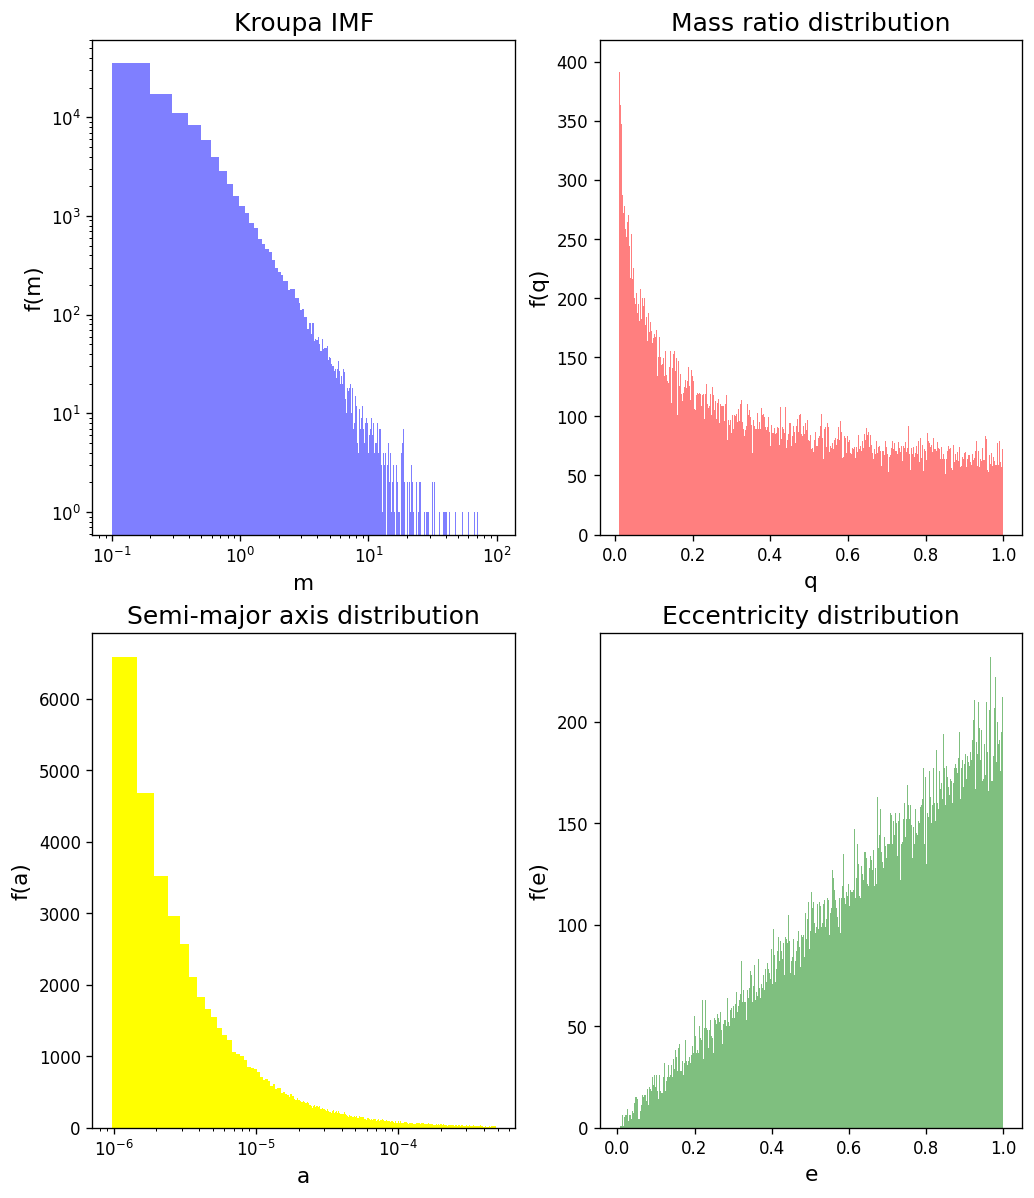

In [27]:
G = 0.00449830997959438 # value for converting velocities from km/s to pc/Myr

Q, N_b, file_dat = main_program(10**3, 15, 0.64)

In [18]:
# Useful information for the input file

print('Virial ratio :', Q)
print('Total number of binaries :', 2*N_b)

Virial ratio : 0.5829442981018891
Total number of binaries : 300
